# 01 - Card pool statistics

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import os
import sqlite3
from numpy.random import default_rng
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats


First we load cards' data from our sqlite database. Database content may vary, so we will work on our sample db from `data/MtgI.db`.

In [3]:
dirname = os.path.dirname('__file__')
db_path = os.path.join(dirname, 'data', 'MtgI.db')
connector = sqlite3.connect(db_path)
cards_data_df = pd.read_sql('SELECT * FROM CardsData', connector)
print(cards_data_df.head())

                            scryfall_id              name  \
0  0000579f-7b35-4ed3-b44c-db2a538066fe       Fury Sliver   
1  00006596-1166-4a79-8443-ca9f82e6db4e     Kor Outfitter   
2  0000cd57-91fe-411f-b798-646e965eec37     Siren Lookout   
3  00012bd8-ed68-4978-a22d-f450c8a6e048               Web   
4  0001f1ef-b957-4a55-b47f-14839cdbab6f  Venerable Knight   

           released_at mana_cost  cmc                type_line  \
0  2006-10-06 00:00:00    {5}{R}  6.0        Creature — Sliver   
1  2009-10-02 00:00:00    {W}{W}  2.0   Creature — Kor Soldier   
2  2017-09-29 00:00:00    {2}{U}  3.0  Creature — Siren Pirate   
3  1994-04-01 00:00:00       {G}  1.0       Enchantment — Aura   
4  2019-10-04 00:00:00       {W}  1.0  Creature — Human Knight   

                                         oracle_text power toughness colors  \
0           All Sliver creatures have double strike.     3         3      R   
1  When Kor Outfitter enters the battlefield, you...     2         2      W   

As you can see there are a lot of different features. This should leave you with more creative freedom, and hopefully deeper insights.
While some columns may still need unpacking, data were previously normalized (using `mtgtop8db` module) so we can start with some basic descriptions of the table, after dropping some useless features.

In [4]:
df = cards_data_df.round(decimals=2)
df.dropna(axis=1,how='all', inplace=True)
df.drop(columns=['scryfall_id'], inplace=True)
print(df.columns.to_list())
print(df.dtypes)

['name', 'released_at', 'mana_cost', 'cmc', 'type_line', 'oracle_text', 'power', 'toughness', 'colors', 'color_identity', 'keywords', 'set_acronym', 'rarity', 'flavor_text', 'produced_mana', 'loyalty', 'alchemy', 'brawl', 'commander', 'duel', 'explorer', 'future', 'gladiator', 'historic', 'historicbrawl', 'legacy', 'modern', 'oldschool', 'pauper', 'paupercommander', 'penny', 'pioneer', 'premodern', 'standard', 'vintage']
name                object
released_at         object
mana_cost           object
cmc                float64
type_line           object
oracle_text         object
power               object
toughness           object
colors              object
color_identity      object
keywords            object
set_acronym         object
rarity              object
flavor_text         object
produced_mana       object
loyalty             object
alchemy             object
brawl               object
commander           object
duel                object
explorer            object
future  

Now, this is a lot of data. Basic description is needed.

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47649 entries, 0 to 47648
Data columns (total 35 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             47649 non-null  object 
 1   released_at      46486 non-null  object 
 2   mana_cost        47649 non-null  object 
 3   cmc              46486 non-null  float64
 4   type_line        47649 non-null  object 
 5   oracle_text      47649 non-null  object 
 6   power            22671 non-null  object 
 7   toughness        22671 non-null  object 
 8   colors           47649 non-null  object 
 9   color_identity   47649 non-null  object 
 10  keywords         47649 non-null  object 
 11  set_acronym      46486 non-null  object 
 12  rarity           46486 non-null  object 
 13  flavor_text      27585 non-null  object 
 14  produced_mana    6606 non-null   object 
 15  loyalty          462 non-null    object 
 16  alchemy          46486 non-null  object 
 17  brawl       

In [6]:
print(df.describe())

                  cmc
count    46486.000000
mean        24.484049
std       4638.073839
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max    1000000.000000


We have only one clearly numerical feature, `cmc`, now called [mana value](https://mtg.fandom.com/wiki/Mana_value).

---
## Mana Value
---
First let's look for outliers:

In [7]:
print(df['cmc'].value_counts())
print(len(df['cmc'].unique()))


3.0          9867
2.0          8942
4.0          7622
0.0          5681
1.0          4899
5.0          4761
6.0          2785
7.0          1180
8.0           463
9.0           158
10.0           70
12.0           21
11.0           21
15.0           10
16.0            2
1000000.0       1
13.0            1
0.5             1
14.0            1
Name: cmc, dtype: int64
20


We have two [funny](https://scryfall.com/card/unh/16/little-girl) [outliers](https://scryfall.com/card/unh/121/gleemax). We will now drop them and look at the cost distribution:

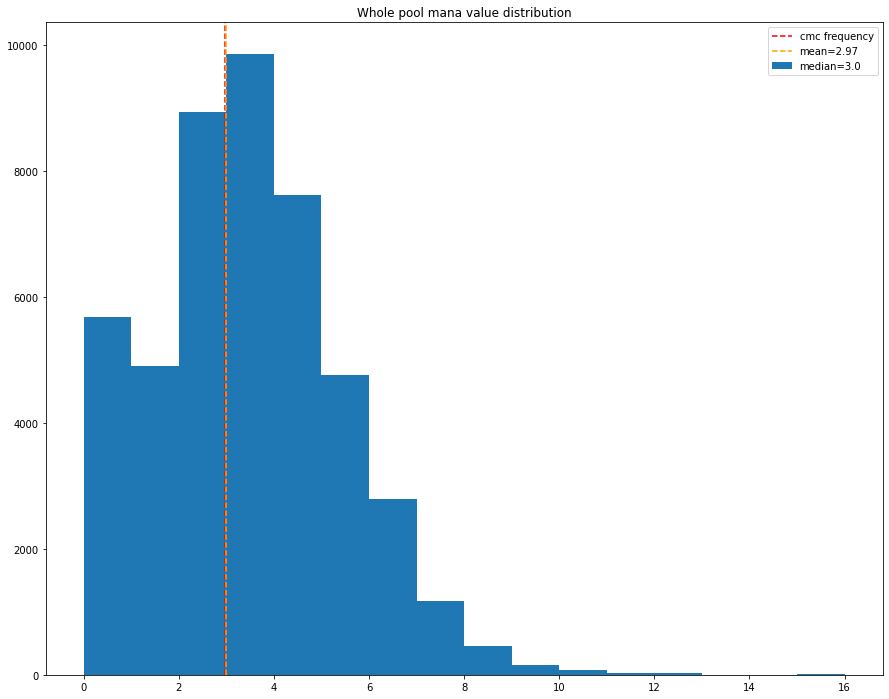

In [8]:
df = df[((df['mana_cost'].notnull())|(df['type_line'].str.contains('land')))&(df['cmc']!=0.5) & (df['cmc']!=10**6)]
plt.figure(figsize=(15,12))
plt.hist(df['cmc'],bins = range(17))
plt.axvline(df['cmc'].mean(), color='r', linestyle='--')
plt.axvline(df['cmc'].median(), color='orange', linestyle='--')
plt.title('Whole pool mana value distribution')
plt.legend(['cmc frequency', f'mean={round(df.cmc.mean(),2)}', f'median={round(df.cmc.median(),2)}'])

We get a bimodal, right-skewed distribution. Remember that lands, basics in particular, are reprinted in almost every set. Dropping them we get surprising results:

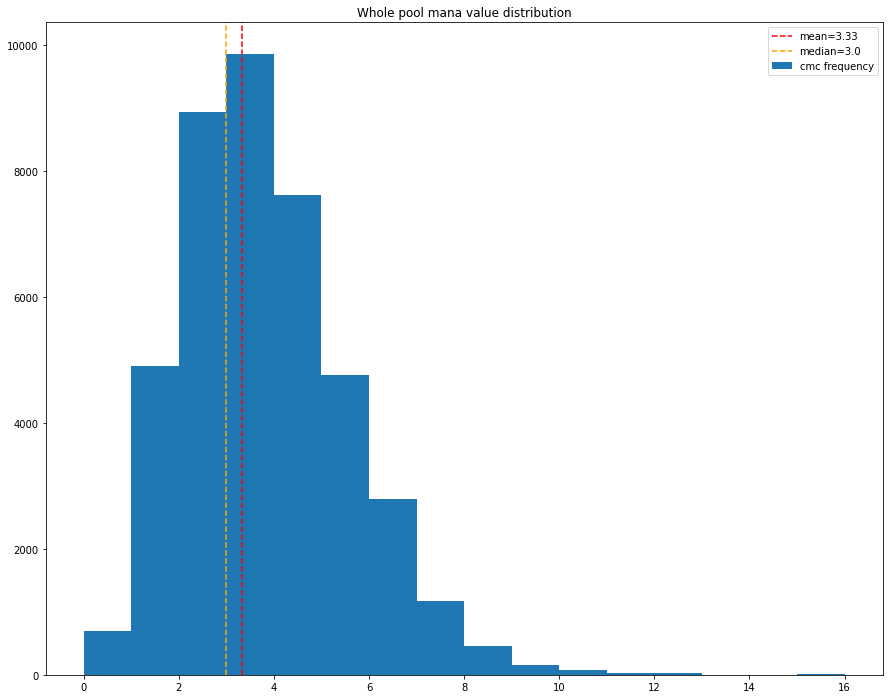

In [10]:
nonland_df=df.loc[~(df['type_line'].str.contains('land', case=False))]
plt.figure(figsize=(15,12))
plt.hist(nonland_df['cmc'],bins=range(17))
plt.axvline(nonland_df['cmc'].mean(), color='r', linestyle='--')
plt.axvline(nonland_df['cmc'].median(), color='orange', linestyle='--')
plt.title('Whole pool mana value distribution')
plt.legend([f'mean={round(nonland_df.cmc.mean(),2)}', f'median={round(nonland_df.cmc.median(),2)}','cmc frequency'])

As you can notice `cmc` looks Poisson distributed. Let's try a $\Chi^2$ test: 

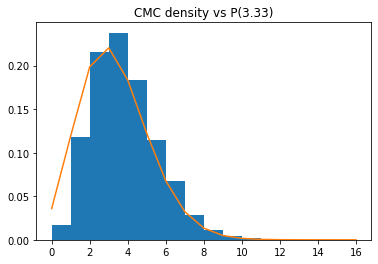

In [36]:
cmcs= nonland_df['cmc']
plt.hist(cmcs,bins = range(17), density=True)
plt.plot(range(17), stats.poisson.pmf(range(17),cmcs.mean()))
plt.title(f'CMC density vs P({round(cmcs.mean(),2)})')
binned_cmcs= nonland_df.groupby('cmc').cmc.count()
cmc_bins= list(binned_cmcs)[:12]
cmc_bins+=[binned_cmcs[13:].sum()]

TODO: chi-square.
While the total card pool is interesting, we can also study single-set or format distributions:

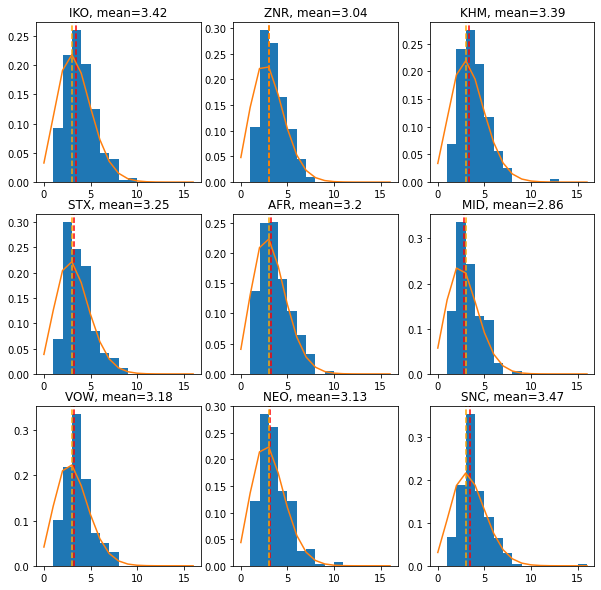

In [12]:
plt.figure(figsize=(10,10))
plt.title('cmc by set')
i=1
for set_acr in ['IKO', 'ZNR', 'KHM', 'STX', 'AFR', 'MID', 'VOW', 'NEO', 'SNC']:
    card_by_set = nonland_df[nonland_df['set_acronym']==set_acr.lower()]
    cmcs = card_by_set['cmc']
    plt.subplot(3,3,i)
    plt.hist(cmcs, bins= range(17), density=True)
    plt.axvline(x=cmcs.mean(), color='r', linestyle='--')
    plt.axvline(x=cmcs.median(), color='orange', linestyle='--')
    plt.title(f'{set_acr}, mean={round(cmcs.mean(),2)}')
    plt.plot(range(17), stats.poisson.pmf(range(17),cmcs.mean()))
    i += 1

Poisson is a much worse fit for sets' mana value distribution: the 0 mana value frequency is always null and 2-3 mana values consitute a large part of the distribution. 6 out of 9 sets are, on average, cheaper then the total pool and most of them are slightly right-skewed. Is there a trend? One could assume that cheaper pools lead to faster (albeit shallower) formats. But those last sets don't tell the whole story. Let's compare formats now.

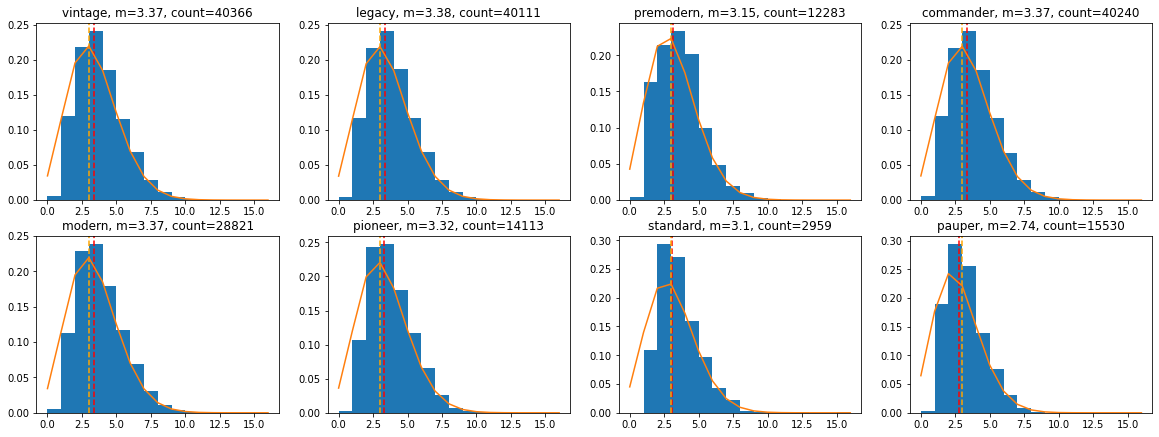

In [16]:
plt.figure(figsize=(20,15))
plt.title('cmc by format')
i=1
for format_tag in ['vintage','legacy','premodern', 'commander','modern','pioneer','standard','pauper']:
    cards_by_format = nonland_df[(nonland_df[format_tag]=='legal')|(nonland_df[format_tag]=='restricted')]
    count = len(cards_by_format)
    cmcs = cards_by_format['cmc']
    plt.subplot(4,4,i)
    plt.hist(cmcs, bins= range(17), density=True)
    plt.axvline(x=cmcs.mean(), color='r', linestyle='--')
    plt.axvline(x=cmcs.median(), color='orange', linestyle='--')
    plt.title(f'{format_tag}, m={round(cmcs.mean(),2)}, count={count}')
    plt.plot(range(17), stats.poisson.pmf(range(17),cmcs.mean()))
    i += 1


No clear trend can be seen. While current Standard (2020 onward) pool is cheaper than average, it is not significantly cheaper than Premodern (1993-2003). Remember that we are talking about card pools: next time we will look at *decks* average mana values.
TODO: Mana value time series, by color and rarity.